In [2]:
import sys
!{sys.executable} -m pip install quandl

  Using cached Quandl-3.6.1-py2.py3-none-any.whl (26 kB)
  Using cached more_itertools-8.7.0-py3-none-any.whl (48 kB)
  Using cached inflection-0.5.1-py2.py3-none-any.whl (9.5 kB)


In [306]:
import quandl
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential, Model
from keras.layers import Dense, RepeatVector, TimeDistributed
from keras.layers import LSTM, Dropout, BatchNormalization, Input
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import scipy.stats
from datetime import datetime, timedelta

quandl.ApiConfig.api_key = 'nEatCp6crNBFgzJkYYG7'
period_in_years = 10

stock_codes = {'reliance':'BSE/BOM500325', 
               'l&t': 'BSE/BOM500510', 
               'dr.reddys': 'BSE/BOM500124', 
               'hdfcltd': 'BSE/BOM500180', 
               'infosys': 'BSE/BOM500209', 
               'bajajfinance': 'BSE/BOM500034', 
               'kotakmahindra': 'BSE/BOM500247', 
               'tcs': 'BSE/BOM532540', 
               'cipla': 'BSE/BOM500087', 
               'abbott': 'BSE/BOM500488'}

reliance
1987.2823
l&t
1409.6439
dr.reddys
5216.259
hdfcltd
1447.5144
infosys
1322.3735
bajajfinance
5757.5347
kotakmahindra
1710.9357
tcs
3046.374
cipla
903.815
abbott
15993.098


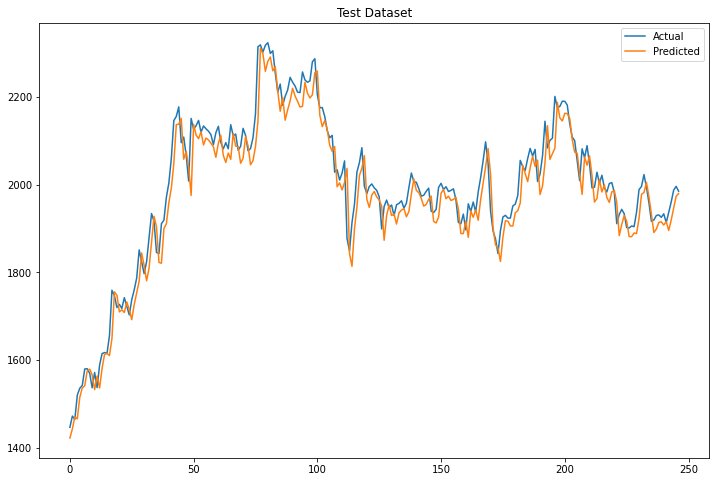

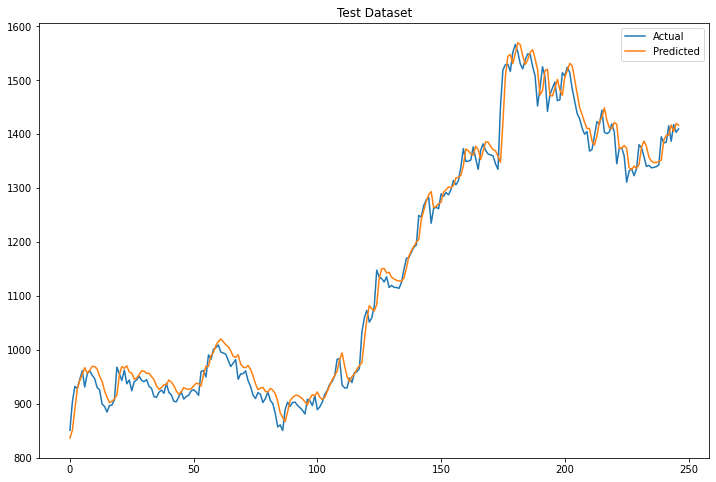

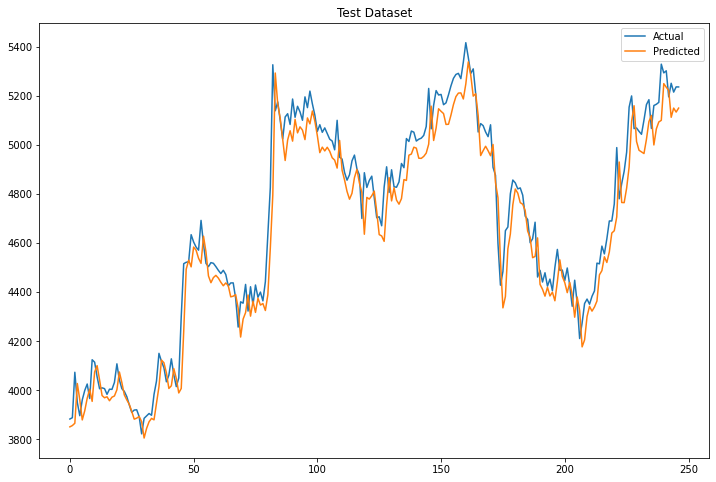

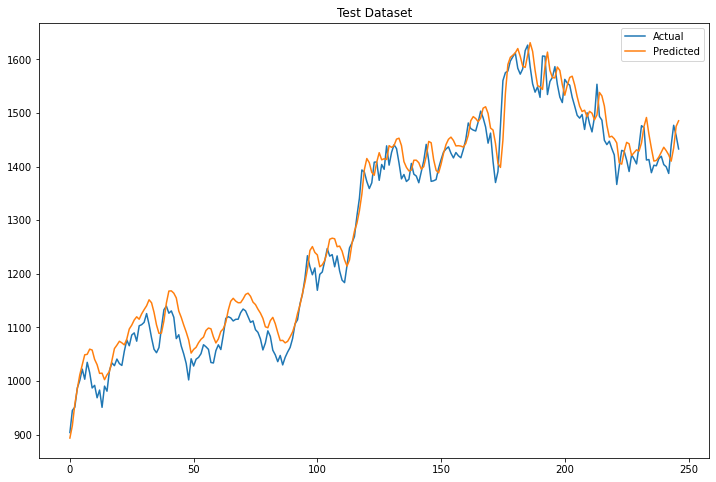

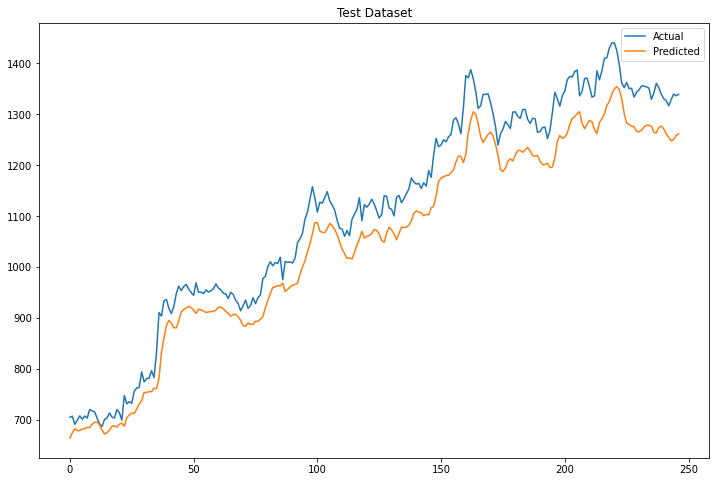

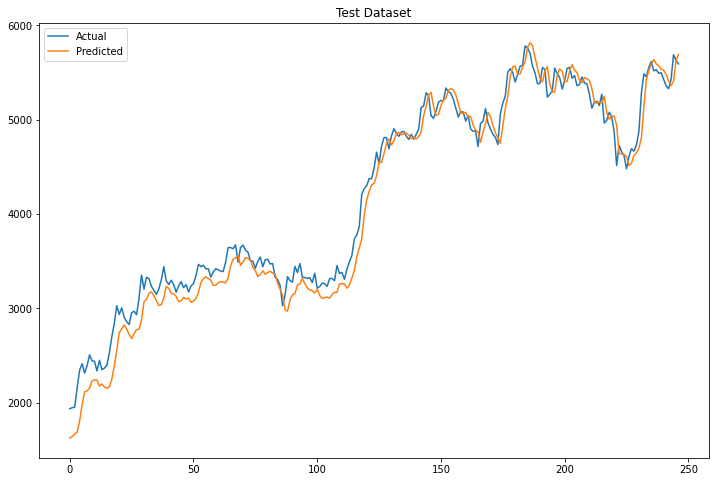

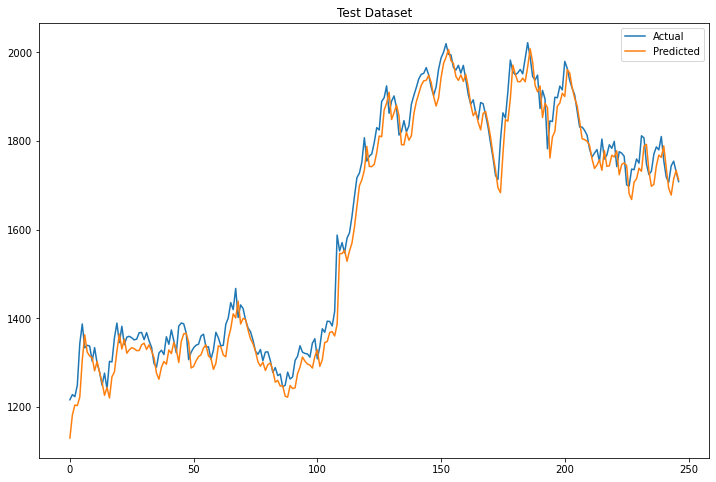

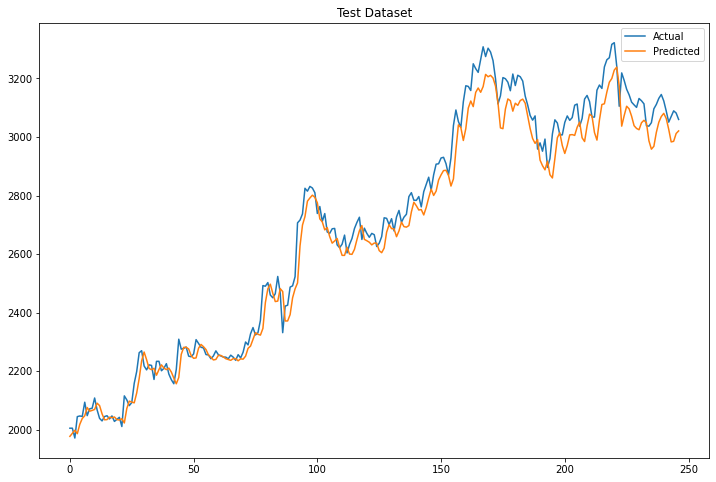

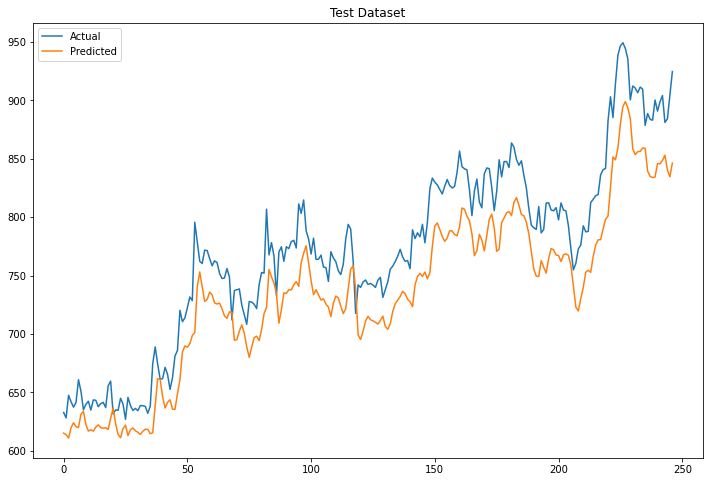

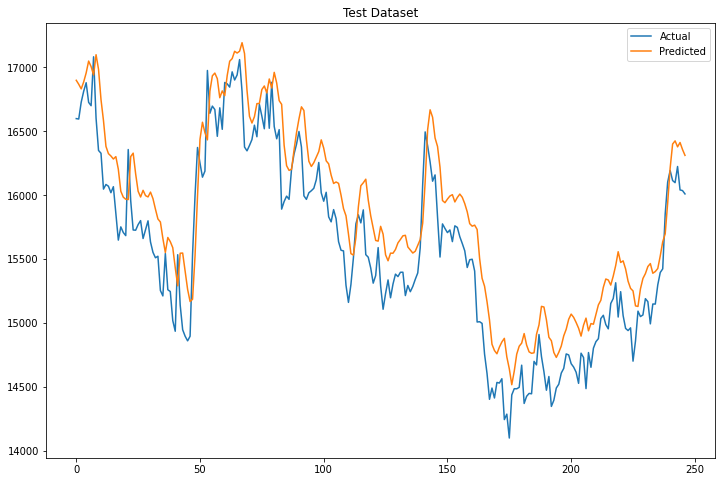

In [282]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)):
        if i+lb < len(data):
            X.append(data[i:(i+lb),0])
            Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

models = {}

for code in stock_codes:
    print(code)
    
    today = datetime.now().date() 
    n_days_ago = today - timedelta(days=period_in_years*365)
    
    df = quandl.get(stock_codes[code], start_date=n_days_ago, end_date=today)
    
    cl = df.Close.astype('float32')
    train = cl[0:]
    scl = MinMaxScaler()
    scl.fit(train.values.reshape(-1,1))
    cl = scl.transform(cl.values.reshape(-1,1))
    
    lb = 5
    
    X,y = processData(cl,lb)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]

    model = Sequential()
    model.add(LSTM(64,input_shape=(lb,1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam',loss='mse')

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

    model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), shuffle=False, verbose=0)
    models[code] = model
    
    plt.figure(figsize=(12,8))
    
    Xt = model.predict(X_test)
    plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
    plt.plot(scl.inverse_transform(Xt), label="Predicted")
    plt.legend()
    plt.title("Test Dataset")
    
    actual = scl.inverse_transform(y_test.reshape(-1,1))
    actual = [x[0] for x in actual]
    
    pred = scl.inverse_transform(Xt)
    pred = [x[0] for x in pred]
    
    diff = np.array(actual)-np.array(pred)
    
    x_test = np.array([cl[len(cl)-lb:len(cl),0]])
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
    pred = scl.inverse_transform(model.predict(x_test))[0][0] + np.mean(diff)
        
    print(pred)

In [233]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

reliance
[1991.0459 1981.7325 1974.7598]
l&t
[1412.8434 1410.2617 1407.8295]
dr.reddys
[5168.5156 5107.3047 5037.2944]
hdfcltd
[1427.5889 1426.4637 1419.7772]
infosys
[1344.2798 1334.4243 1332.2725]
bajajfinance
[5583.206  5605.4077 5622.2734]
kotakmahindra
[1730.5461 1721.1313 1725.8665]
tcs
[3087.9893 3097.8809 3096.6577]
cipla
[910.6168  907.1439  894.79346]
abbott
[16022.33  15980.973 15916.187]


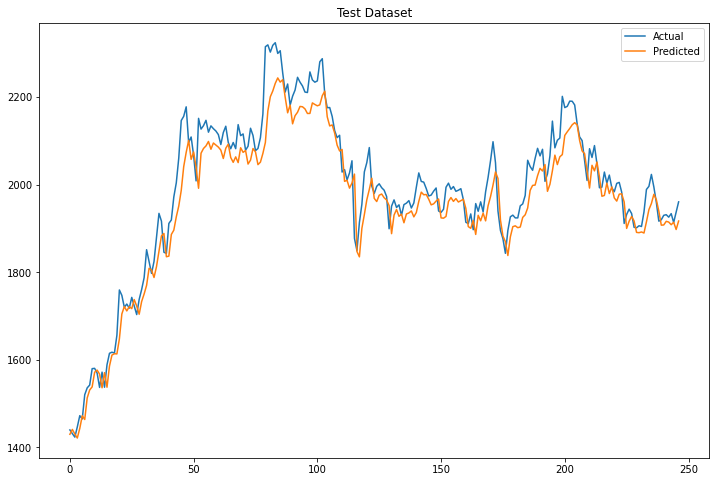

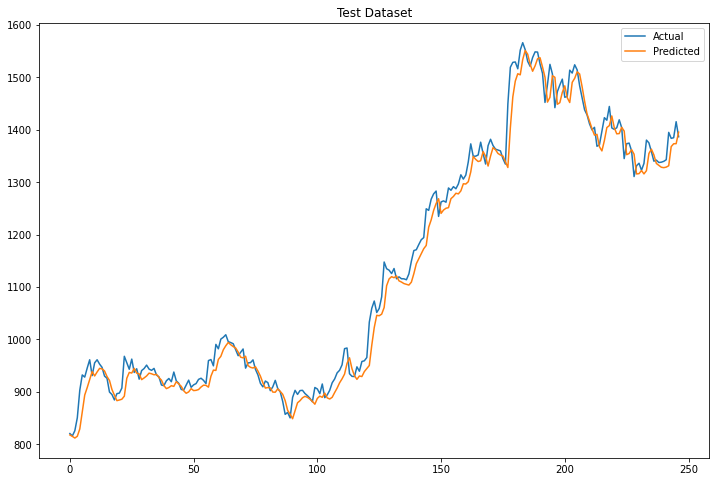

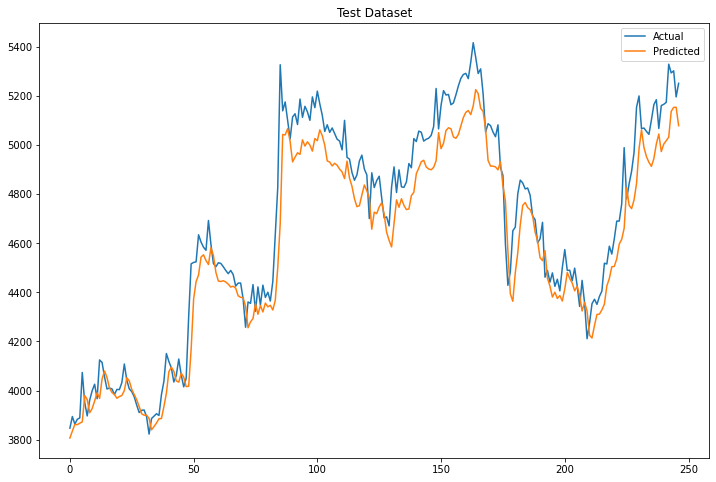

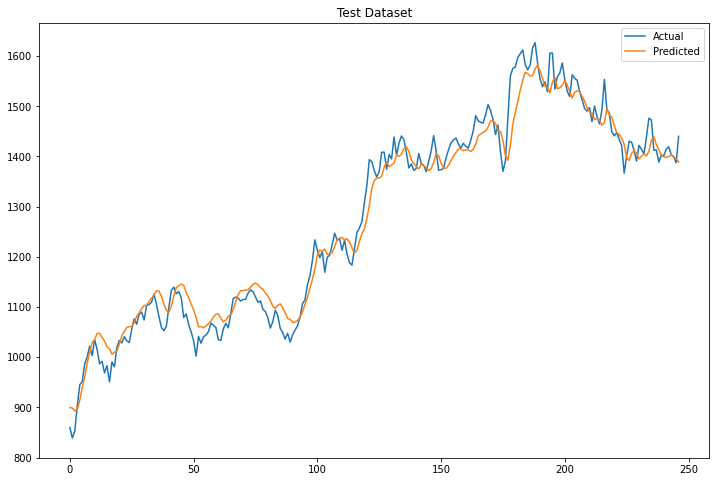

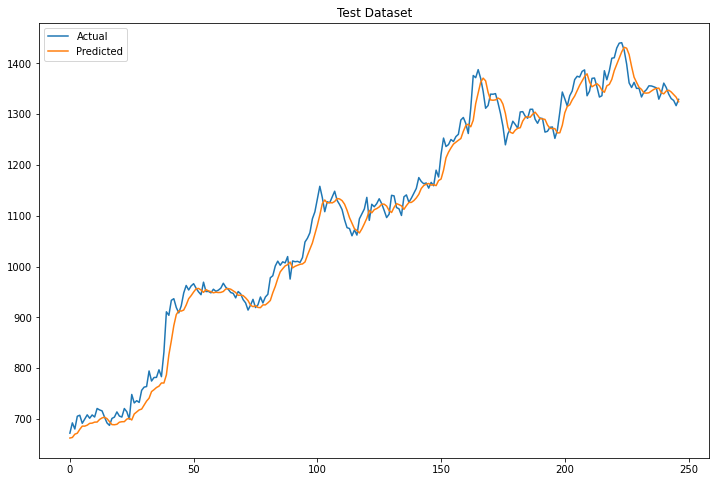

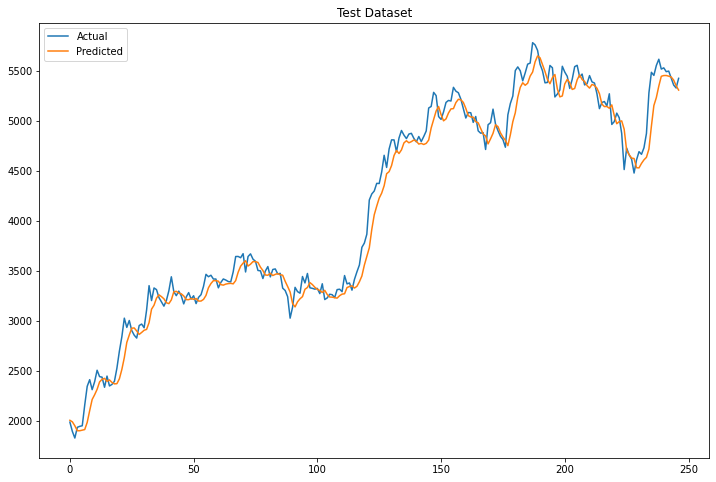

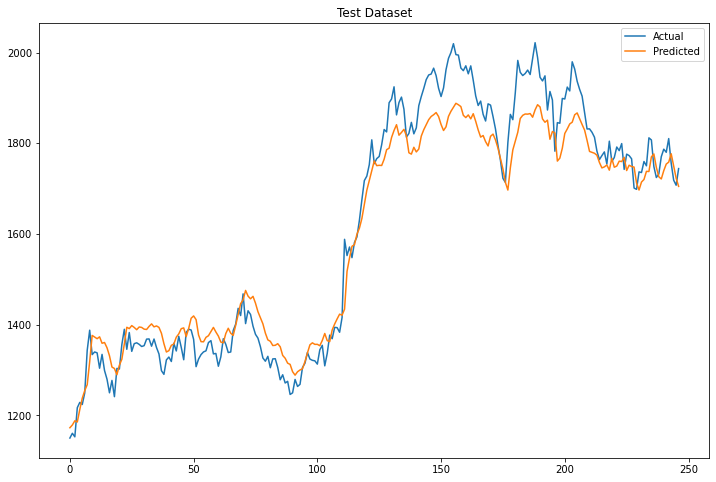

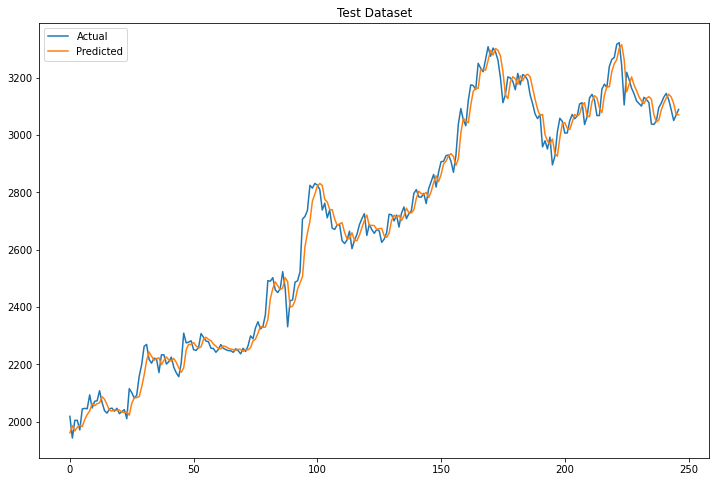

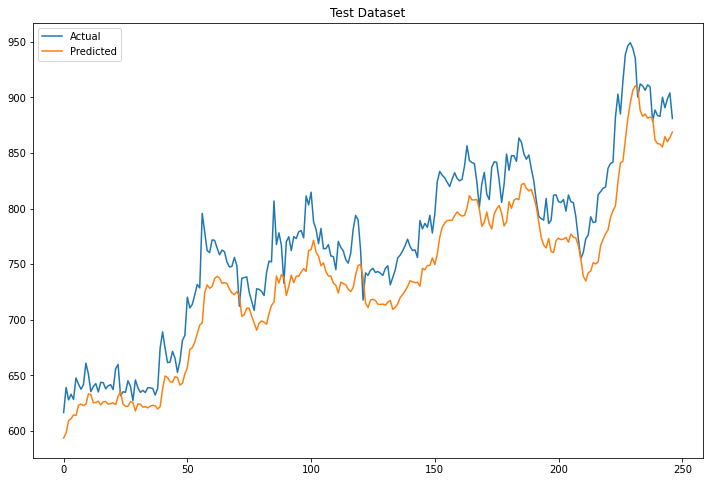

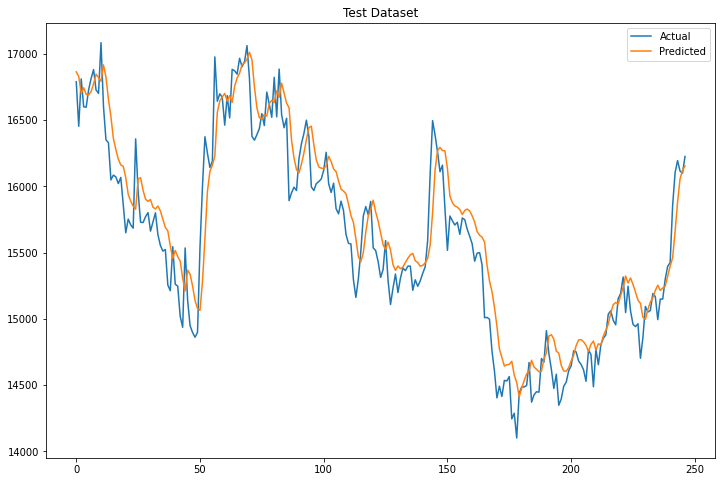

In [403]:
def processData(data,lb,la):
    X,Y = [],[]
    for i in range(len(data)):
        if i+lb+la < len(data):
            X.append(data[i:(i+lb),0])
            Y.append(data[(i+lb):(i+lb+la),0])
    return np.array(X),np.array(Y)

models = {}

for code in stock_codes:
    print(code)
    
    today = datetime.now().date() 
    n_days_ago = today - timedelta(days=period_in_years*365)
    
    df = quandl.get(stock_codes[code], start_date=n_days_ago, end_date=today)
    
    cl = df.Close.astype('float32')
    train = cl[0:]
    scl = MinMaxScaler()
    scl.fit(train.values.reshape(-1,1))
    cl = scl.transform(cl.values.reshape(-1,1))
    
    lb, la = 7, 3

    X,y = processData(cl,lb,la)
    X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
    y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
    
    encoder_inputs = Input(shape=(lb, 1))
    encoder_l1 = LSTM(16, activation='relu', return_state=True)
    encoder_outputs1 = encoder_l1(encoder_inputs)

    encoder_states1 = encoder_outputs1[1:]

    decoder_inputs = RepeatVector(la)(encoder_outputs1[0])
    decoder_l1 = LSTM(16, activation='relu', return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
    decoder_outputs1 = TimeDistributed(Dense(1))(decoder_l1)

    model = Model(encoder_inputs,decoder_outputs1)
    model.compile(loss='mae', optimizer='adam')

    X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
    X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))
    y_train = y_train.reshape((y_train.shape[0],y_train.shape[1],1))
    y_test = y_test.reshape((y_test.shape[0],y_test.shape[1],1))

    model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), shuffle=False, verbose=0)
    models[code] = model
    
    plt.figure(figsize=(12,8))
    
    Xt = model.predict(X_test)
    plt.plot(scl.inverse_transform(y_test[:,0].reshape(-1,1)), label="Actual")
    plt.plot(scl.inverse_transform(Xt[:,0].reshape(-1,1)), label="Predicted")
    plt.legend()
    plt.title("Test Dataset")
    
    actual = scl.inverse_transform(y_test[:,0].reshape(-1,1))
    actual = [x[0] for x in actual]
    
    pred = scl.inverse_transform(Xt[:,0].reshape(-1,1))
    pred = [x[0] for x in pred]
    
    diff = np.array(actual)-np.array(pred)
    
    x_test = np.array([cl[-lb:,0]])
    x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
    pred = model.predict(x_test)
    pred = scl.inverse_transform(pred[0])
    pred = [x[0] for x in pred]
    pred = np.array(pred) + np.mean(diff)
        
    print(pred)

In [ ]:
5392bf76afe7665f7708003bf35ac305ffd6752ce3c5842079e0c26e5946c501

In [427]:
import requests
import datetime

def gt(dt_str):
    dt, _, us = dt_str.partition(".")
    dt = datetime.datetime.strptime(dt, "%Y-%m-%dT%H:%M:%S")
    us = int(us.rstrip("Z"), 10)
    return dt + datetime.timedelta(microseconds=us)

output = []
start = '2010-05-22T00:00:00'

while True:
    url = 'https://rest.coinapi.io/v1/exchangerate/BTC/INR/history?period_id=1DAY&time_start=' + start + '&time_end=2021-05-22T00:00:00'
    headers = {'X-CoinAPI-Key' : 'CFC32C79-1646-45E5-9A6A-ABEFEF9540C0'}
    response = requests.get(url, headers=headers)
    output += response.json()
    print(len(output))
    curr = str(gt(output[-1]['time_period_start']).date())
    if curr == '2021-05-22':
        break
    start = output[-1]['time_period_end']

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
3950
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961
3961

KeyboardInterrupt: 

In [429]:
import pickle

In [430]:
with open('btc_prices.pkl', 'wb') as f:
    pickle.dump(output, f)

In [431]:
output[-1]

{'time_period_start': '2021-05-21T00:00:00.0000000Z',
 'time_period_end': '2021-05-22T00:00:00.0000000Z',
 'time_open': '2021-05-21T00:00:00.0000000Z',
 'time_close': '2021-05-21T23:59:00.0000000Z',
 'rate_open': 2983842.676795823,
 'rate_high': 3067146.8093646984,
 'rate_low': 2713415.3803637694,
 'rate_close': 2734521.377015573}

In [433]:
import pandas as pd
df = pd.DataFrame(output)

In [434]:
df

,time_period_start,time_period_end,time_open,time_close,rate_open,rate_high,rate_low,rate_close
0,2010-07-18T00:00:00.0000000Z,2010-07-19T00:00:00.0000000Z,2010-07-18T17:48:00.0000000Z,2010-07-18T22:00:00.0000000Z,4.091860e+00,5.804232e+00,4.317025e+00,6.025711e+00
1,2010-07-19T00:00:00.0000000Z,2010-07-20T00:00:00.0000000Z,2010-07-19T16:24:00.0000000Z,2010-07-19T21:02:00.0000000Z,6.303947e+00,6.308477e+00,5.749330e+00,5.426327e+00
2,2010-07-20T00:00:00.0000000Z,2010-07-21T00:00:00.0000000Z,2010-07-20T03:54:00.0000000Z,2010-07-20T21:29:00.0000000Z,5.744105e+00,5.595206e+00,5.407541e+00,5.224757e+00
3,2010-07-21T00:00:00.0000000Z,2010-07-22T00:00:00.0000000Z,2010-07-21T02:30:00.0000000Z,2010-07-21T23:54:00.0000000Z,5.173873e+00,5.320275e+00,4.661618e+00,5.455421e+00
4,2010-07-22T00:00:00.0000000Z,2010-07-23T00:00:00.0000000Z,2010-07-22T00:50:00.0000000Z,2010-07-22T23:56:00.0000000Z,5.498034e+00,5.584814e+00,3.917786e+00,4.114417e+00
...,...,...,...,...,...,...,...,...
3956,2021-05-17T00:00:00.0000000Z,2021-05-18T00:00:00.0000000Z,2021-05-17T00:00:00.0000000Z,2021-05-17T23:59:00.0000000Z,3.396129e+06,3.381529e+06,3.105459e+06,3.178433e+06
3957,2021-05-18T00:00:00.0000000Z,2021-05-19T00:00:00.0000000Z,2021-05-18T00:00:00.0000000Z,2021-05-18T23:59:00.0000000Z,3.184703e+06,3.325349e+06,3.104136e+06,3.132299e+06
3958,2021-05-19T00:00:00.0000000Z,2021-05-20T00:00:00.0000000Z,2021-05-19T00:00:00.0000000Z,2021-05-19T23:59:00.0000000Z,3.130453e+06,3.036033e+06,2.271643e+06,2.715671e+06
3959,2021-05-20T00:00:00.0000000Z,2021-05-21T00:00:00.0000000Z,2021-05-20T00:00:00.0000000Z,2021-05-20T23:59:00.0000000Z,2.707214e+06,3.101145e+06,2.604081e+06,2.982027e+06


In [439]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)):
        if i+lb < len(data):
            X.append(data[i:(i+lb),0])
            Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

cl = df.rate_close.astype('float32')
train = cl[0:]
scl = MinMaxScaler()
scl.fit(train.values.reshape(-1,1))
cl = scl.transform(cl.values.reshape(-1,1))

lb = 3

X,y = processData(cl,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]

Epoch 1/100
112/112 [==============================] - 6s 12ms/step - loss: 1.6597e-04 - val_loss: 0.0920
Epoch 2/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0025 - val_loss: 0.0783
Epoch 3/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0744
Epoch 4/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0614
Epoch 5/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0029 - val_loss: 0.0418
Epoch 6/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0023 - val_loss: 0.0187
Epoch 7/100
112/112 [==============================] - 0s 3ms/step - loss: 0.0014 - val_loss: 0.0121
Epoch 8/100
112/112 [==============================] - 0s 3ms/step - loss: 5.4080e-04 - val_loss: 0.0194
Epoch 9/100
112/112 [==============================] - 0s 3ms/step - loss: 1.8285e-04 - val_loss: 0.0303
Epoch 10/100
112/112 [==============================] - 0s 3ms/step - loss: 8.

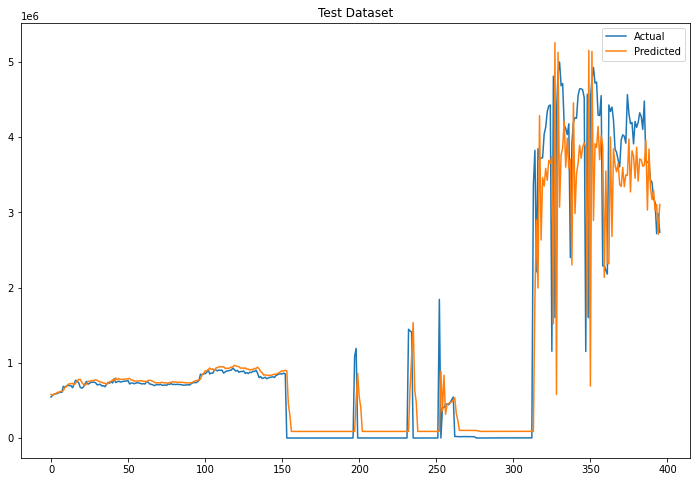

In [444]:
model = Sequential()
model.add(LSTM(16,input_shape=(lb,1), return_sequences=True))
model.add(LSTM(16))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')

X_train = X_train.reshape((X_train.shape[0],X_train.shape[1],1))
X_test = X_test.reshape((X_test.shape[0],X_test.shape[1],1))

model.fit(X_train, y_train, epochs=100, validation_data=(X_test,y_test), shuffle=False)

plt.figure(figsize=(12,8))

Xt = model.predict(X_test)
plt.plot(scl.inverse_transform(y_test.reshape(-1,1)), label="Actual")
plt.plot(scl.inverse_transform(Xt), label="Predicted")
plt.legend()
plt.title("Test Dataset")

actual = scl.inverse_transform(y_test.reshape(-1,1))
actual = [x[0] for x in actual]

pred = scl.inverse_transform(Xt)
pred = [x[0] for x in pred]

diff = np.array(actual)-np.array(pred)

x_test = np.array([cl[len(cl)-lb:len(cl),0]])
x_test = x_test.reshape((x_test.shape[0],x_test.shape[1],1))
pred = scl.inverse_transform(model.predict(x_test))[0][0] + np.mean(diff)

print(pred)